# TensorFlow LSTM metrics
Model: TF-LSTM

Dataset: Electricity

Here we attempt to replicate the results from deepar_metrics.ipynb and deepar_metrics_continued.ipynb. Can we find similar patterns of good and bad seeds for a LSTM implemented in TensorFlow?


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.metrics import *

In [2]:
experiment_path = "/home/dev/deepts/experiments/tf_lstm/electricity/1B"
repetitions = []
for folder in sorted(os.listdir(experiment_path)):
    repetitions.append(pd.read_csv(f"{experiment_path}/{folder}/forecasts.csv", index_col=0).rename_axis("index"))

len(repetitions)

100

In [3]:
repetitions[0].head()

,series_number,timestamp,target,sample0
index,,,,
1.0,0,2014-05-26 20:00:00,9.0,6.935253
1.0,0,2014-05-26 21:00:00,10.0,7.887085
1.0,0,2014-05-26 22:00:00,22.0,8.809139
1.0,0,2014-05-26 23:00:00,20.0,9.658505
1.0,0,2014-05-27 00:00:00,13.0,10.396960


In [4]:
exp = []
for rep in repetitions:
    array = rep[["target", "sample0"]].values
    array = array.reshape((2247, 24, 2))

    mse = np.mean(np.square(array[:, :, 0] - array[:, :, 1]), axis=1).reshape((-1, 321))
    
    # Calculate MAPE like in GluonTS evaluator
    denominator = np.abs(array[:, :, 0])
    flag = denominator == 0
    mape = np.mean(np.abs(array[:, :, 0] - array[:, :, 1]) * (1 - flag) / (denominator + flag), axis=1).reshape((-1, 321))

    metrics_df = pd.DataFrame(
        data=np.concatenate([mape.reshape(-1, 1), mse.reshape(-1, 1)], axis=-1),
        columns=["MAPE", "MSE"]
        ).rename_axis("index")
    metrics_df["item_id"] = metrics_df.index % 321
    exp.append(metrics_df)

exp[0].head()



,MAPE,MSE,item_id
index,,,
0,0.546430,24.866209,0
1,0.152825,349.835327,1
2,0.076650,0.706183,2
3,0.149300,8019.084510,3
4,0.113463,851.756621,4


### Differences in metrics between different seeds

In [5]:
report_experiment_results(exp, ["MSE", "MAPE"])

(MSE) Highest value: 54085808.0
(MSE) Lowest value:  4491171.0
(MSE) Difference between highest and lowest: 49594636.0
(MSE) Difference between average error, 10 highest - 10 lowest: 38391040.0

(MAPE) Highest value: 0.5945866703987122
(MAPE) Lowest value:  0.2194463461637497
(MAPE) Difference between highest and lowest: 0.37514030933380127
(MAPE) Difference between average error, 10 highest - 10 lowest: 0.17820709943771362

Most occuring repetitions worst 10 (repetition, frequency): {42: 2, 26: 2, 87: 2, 43: 2, 33: 2, 52: 1, 78: 1, 80: 1, 22: 1, 45: 1, 74: 1, 68: 1, 3: 1, 46: 1, 81: 1}
Most occuring repetitions best 10 (repetition, frequency): {10: 2, 91: 1, 82: 1, 67: 1, 4: 1, 77: 1, 95: 1, 23: 1, 8: 1, 94: 1, 90: 1, 48: 1, 38: 1, 21: 1, 40: 1, 20: 1, 99: 1, 57: 1, 76: 1}
Total number of different repetitions present across metrics (highest): 15
Total number of different repetitions present across metrics (lowest): 19



### The best and worst metric-value for all timeseries. Which repetitions are most common?

In [6]:
metric = ["MAPE"]
exp_array = calculate_timeseries_means(exp, metric, 321)
exp_array.shape

(100, 321, 1)

In [7]:
exp[0].head(10)

,MAPE,MSE,item_id
index,,,
0,0.546430,24.866209,0
321,0.780673,138.489741,0
642,0.530146,113.263705,0
963,1.490859,81.369509,0
1284,0.874637,12.545066,0
1605,0.669063,11.529887,0
1926,0.326690,47.197466,0
1,0.152825,349.835327,1
322,0.179029,402.931738,1


(array([  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        274,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   0,   0,  35,   0,   0,   0,   4,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([16, 26, 42, 46, 74]))

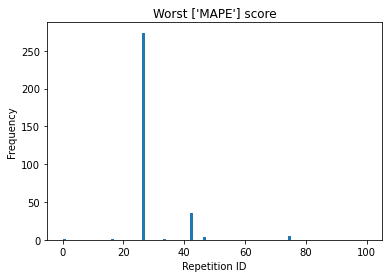

In [8]:
exp_max_bin, exp_worst_reps = find_n_most_frequent_repetitions(exp_array, 5, np.argmax)
plt.hist([i for i in range(100)], bins=100, range=(0, 100), weights=exp_max_bin)
plt.title(f"Worst {metric} score")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

exp_max_bin, exp_worst_reps

(array([ 1,  2,  0,  0,  1,  3,  0,  0,  5,  1, 42,  3,  2,  0,  0,  0,  0,
         0,  0,  0,  5,  4, 15,  0,  0,  0,  0,  5,  3,  5,  3,  0,  7,  0,
         0,  0,  0,  0,  8,  9, 43,  0,  1,  1,  0,  0,  0,  0, 73,  0,  0,
         0,  6,  4,  1,  0,  0,  0,  1,  0,  0,  2,  0,  1,  0,  0,  0,  1,
         7,  0,  0,  6,  8,  0,  1,  2,  0,  0,  4,  9,  2,  0,  0,  2,  0,
         0,  2,  2,  5,  0,  1,  0,  0,  1,  0,  0,  0,  6,  1,  4]),
 array([39, 22, 10, 40, 48]))

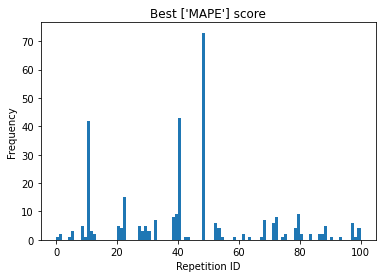

In [9]:
exp_min_bin, exp_best_reps = find_n_most_frequent_repetitions(exp_array, 5, np.argmin)
plt.hist([i for i in range(100)], bins=100, range=(0, 100), weights=exp_min_bin)
plt.title(f"Best {metric} score")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

exp_min_bin, exp_best_reps

### The top n best and worst scoring seeds

In [10]:
n = 10

(array([  0.,   1.,   1., 175.,  23.,   0.,   8.,   0.,   0.,   1.,   0.,
        134.,   6.,   0.,   0.,   0.,  48.,   0.,   0.,   0.,   0.,   0.,
          5.,   0.,   0.,   0., 291.,   1.,   1.,  67.,   1.,  13.,   1.,
        233.,   0.,  98.,   7.,   2.,   0.,   0.,   1.,   0., 185., 166.,
         61.,  29., 135.,  82.,   0.,  50.,  35.,   0., 165.,   0.,  38.,
          4.,   0.,   0.,   0.,   0.,  38.,   0.,   0.,   3.,   0.,   1.,
          1.,   0., 108., 117.,   0.,   0.,   0.,   0., 306.,   0.,   0.,
          0.,  46.,   6.,  72., 181.,  33.,  18.,  14.,   0.,   0., 145.,
          4.,   0.,   0.,   0.,   5.,  10.,   6.,   1.,  26.,   0.,   0.,
          1.]),
 array([74, 26, 33, 42, 81,  3, 43, 52, 87, 46]),
 array([306., 291., 233., 185., 181., 175., 166., 165., 145., 135.]))

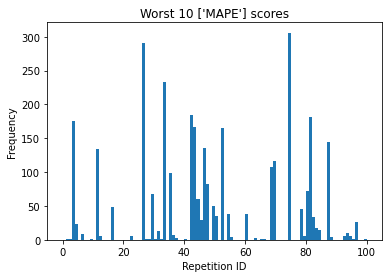

In [11]:
indexes_worst10, worst10 = np.unique(np.argsort(exp_array, axis=0)[-n:], return_counts=True)
worst_10_count = count_repetitions_among_top_n(indexes_worst10, worst10, 100)
plt.title(f"Worst 10 {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(100)], bins=100, range=(0, 100), weights=worst_10_count)

worst_10_count, np.argsort(worst_10_count)[-10:][::-1], worst_10_count[np.argsort(worst_10_count)[-10:][::-1]]

(array([  2.,  71.,   0.,   2.,  28.,  18.,   1.,  35.,  98.,   3., 189.,
         10.,  29.,   2.,   2.,  14.,   7.,  20.,   4.,  18., 160., 116.,
         34.,  63.,  10.,  23.,   3.,  26.,  37.,  26.,  18.,   1.,  76.,
         10.,  13.,   4.,   1.,   3., 175., 109., 152.,  23.,  24.,  25.,
         10.,  28.,   0.,   4., 216.,   2.,  26.,   4.,  17.,  32.,  10.,
          0.,   2., 150.,  32.,  15.,  15.,  20.,   2.,   2.,   3.,   9.,
         23.,  55.,  22.,   1.,   3.,  34.,  54.,   0.,   2.,  45.,  97.,
         60.,  24.,  44.,  35.,   0.,   1.,  14.,   9.,   2.,  35.,  26.,
         25.,   0., 164.,   6.,   0.,   1.,   6.,   0.,   2.,  42.,  16.,
         78.]),
 array([48, 10, 38, 90, 20, 40, 57, 21, 39,  8]),
 array([216., 189., 175., 164., 160., 152., 150., 116., 109.,  98.]))

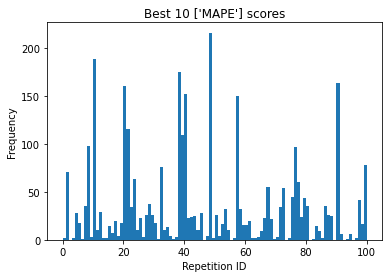

In [12]:
indexes_best10, best10 = np.unique(np.argsort(exp_array, axis=0)[:n], return_counts=True)
best_10_count = count_repetitions_among_top_n(indexes_best10, best10, 100)
plt.title(f"Best 10 {metric} scores")
plt.xlabel("Repetition ID")
plt.ylabel("Frequency")

plt.hist([i for i in range(100)], bins=100, range=(0, 100), weights=best_10_count)

best_10_count, np.argsort(best_10_count)[-10:][::-1], best_10_count[np.argsort(best_10_count)[-10:][::-1]]